In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load metadata
metadata = pd.read_excel("D:\\My_Acad\\VS_Code\\Sem_6_code\\DL\\project\\kishore_code\\VQA_RAD Dataset Public.xlsx")

In [4]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2248 entries, 0 to 2247
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   QID_unique    2248 non-null   int64 
 1   QID_para      2248 non-null   object
 2   QID_linked    2248 non-null   object
 3   IMAGEID_case  2248 non-null   object
 4   IMAGEID       2248 non-null   object
 5   IMAGEORGAN    2248 non-null   object
 6   EVALUATION    2248 non-null   object
 7   QUESTION      2248 non-null   object
 8   Q_REPHASE     1776 non-null   object
 9   Q_RELATION    1487 non-null   object
 10  Q_FRAMED      1267 non-null   object
 11  Q_TYPE        2248 non-null   object
 12  ANSWER        2247 non-null   object
 13  A_TYPE        2248 non-null   object
dtypes: int64(1), object(13)
memory usage: 246.0+ KB


In [5]:
metadata["Q_TYPE"].value_counts()

Q_TYPE
PRES            800
POS             316
ABN             202
OTHER           194
MODALITY        185
SIZE            171
PLANE           120
ATTRIB           87
ORGAN            59
COLOR            52
COUNT            24
POS, PRES         6
PRES, ATTRIB      6
PRES, POS         4
ATTRIB, PRES      4
ABN, POS          3
SIZE, PRES        2
Other             2
COLOR, PRES       2
POS, ABN          2
SIZE, COLOR       2
ATTRIB, SIZE      1
PRES, ABN         1
PRES, COLOR       1
ATRIB             1
PRSE              1
Name: count, dtype: int64

In [6]:
metadata.isna().sum()

QID_unique        0
QID_para          0
QID_linked        0
IMAGEID_case      0
IMAGEID           0
IMAGEORGAN        0
EVALUATION        0
QUESTION          0
Q_REPHASE       472
Q_RELATION      761
Q_FRAMED        981
Q_TYPE            0
ANSWER            1
A_TYPE            0
dtype: int64

In [7]:
metadata["A_TYPE"].value_counts()

A_TYPE
CLOSED     1297
OPEN        949
CLOSED        2
Name: count, dtype: int64

In [8]:
metadata["ANSWER"].value_counts()[:20]

ANSWER
No                                      486
Yes                                     347
yes                                     239
no                                      120
Axial                                    28
Right                                    22
Left                                     18
PA                                       15
axial                                    15
CT                                       13
Brain                                    10
MRI                                       8
Right side                                8
fat                                       7
Right upper lobe                          7
Right lung                                7
5.6cm focal, predominantly hypodense      6
Bilateral                                 6
Diffuse                                   6
Left kidney                               6
Name: count, dtype: int64

<Axes: xlabel='IMAGEORGAN'>

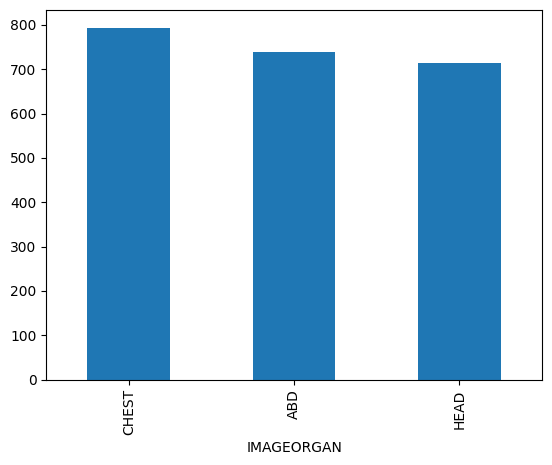

In [9]:
metadata["IMAGEORGAN"].value_counts().plot.bar()

In [10]:
# Filter metadata to include only entries with A_TYPE as "CLOSED"
metadata = metadata[metadata["A_TYPE"] == "CLOSED"]

In [11]:
# Further filter metadata to include only entries with "yes" and "no" answers
sampledata = metadata[(metadata["ANSWER"].str.lower() == "yes") | (metadata["ANSWER"].str.lower() == "no")]
sampledata.reset_index(inplace=True, drop=True)

In [12]:
# Convert answers to binary labels
labels = sampledata["ANSWER"].str.lower().map({'yes': 1, 'no': 0}).values
print(labels)

[1 0 0 ... 1 1 1]


In [13]:
# Tokenize questions
docx = sampledata["QUESTION"].tolist()
tokenizer = Tokenizer(oov_token="<nothing>")
tokenizer.fit_on_texts(docx)
sequences = tokenizer.texts_to_sequences(docx)
sequences = pad_sequences(sequences, padding="post", maxlen=10)

In [14]:
print(sequences)

[[  9 478   8 ...   0   0   0]
 [  9   3  49 ...   0   0   0]
 [  2   4  15 ...   0   0   0]
 ...
 [  2   4 458 ...   0   0   0]
 [  2   5   7 ...   0   0   0]
 [  2   5  82 ... 204   0   0]]


In [15]:
# Prepare image addresses
IMGDIR = "D:\\My_Acad\\VS_Code\\Sem_6_code\\DL\\project\\kishore_code\\VQA_RAD Image Folder\\"
addresses = [IMGDIR + img_id.split('/')[-1] for img_id in sampledata["IMAGEID"]]

In [16]:
# Split data into training and validation sets
train_addresses, val_addresses, ytrain, ytest = train_test_split(addresses, labels, test_size=0.2, random_state=42)
train_sequences, val_sequences, ytrain, ytest = train_test_split(sequences, labels, test_size=0.2, random_state=42)

## **In Built Model(VGG16, RESNET50)**

In [17]:
from PIL import Image

# Data augmentation and processing functions
def augment_data(image):
    # Convert numpy array to PIL image
    image = Image.fromarray(image)
    transform = transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ])
    return transform(image)

def process_data(image_path, text_sequence, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = augment_data(image)
    text_sequence = torch.tensor(text_sequence, dtype=torch.long)
    label = torch.tensor(label, dtype=torch.float32)
    return (image, text_sequence), label

In [18]:
class VQADataset(Dataset):
    def __init__(self, addresses, sequences, labels):
        self.addresses = addresses
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.addresses)

    def __getitem__(self, idx):
        return process_data(self.addresses[idx], self.sequences[idx], self.labels[idx])

In [19]:
BATCH_SIZE = 32
BUFFER_SIZE = 500

train_dataset = VQADataset(train_addresses, train_sequences, ytrain)
val_dataset = VQADataset(val_addresses, val_sequences, ytest)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:

# Define the model
class VQAModel(nn.Module):
    def __init__(self, base_model, vocab_size, feature_size):
        super(VQAModel, self).__init__()
        self.base_model = base_model
        self.text_embedding = nn.Embedding(vocab_size, 64)
        self.lstm = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(feature_size + 128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, image, text):
        img_features = self.base_model(image)
        text_features, _ = self.lstm(self.text_embedding(text))
        text_features = self.dropout(text_features[:, -1, :])
        combined_features = torch.cat((img_features, text_features), dim=1)
        x = self.dropout(torch.relu(self.fc1(combined_features)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))
        return x

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
# Load pre-trained models
vocab_size = sequences.max() + 1
print(vocab_size)

820


In [23]:
resnet_model = models.resnet50(pretrained=True)
vgg_model = models.vgg16(pretrained=True)

models_dict = {
    'ResNet': resnet_model,
    'VGGNet': vgg_model
}

VQAModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

100%|██████████| 30/30 [00:15<00:00,  1.99it/s]


Epoch 0/24, Loss: 0.7193, Accuracy: 0.5257


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]


Epoch 1/24, Loss: 0.7070, Accuracy: 0.5110


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Epoch 2/24, Loss: 0.6923, Accuracy: 0.5414


100%|██████████| 30/30 [00:10<00:00,  2.76it/s]


Epoch 3/24, Loss: 0.6958, Accuracy: 0.5278


100%|██████████| 30/30 [00:09<00:00,  3.11it/s]


Epoch 4/24, Loss: 0.6852, Accuracy: 0.5750


100%|██████████| 30/30 [00:10<00:00,  2.79it/s]


Epoch 5/24, Loss: 0.6880, Accuracy: 0.5656


100%|██████████| 30/30 [00:10<00:00,  2.96it/s]


Epoch 6/24, Loss: 0.6877, Accuracy: 0.5530


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


Epoch 7/24, Loss: 0.6874, Accuracy: 0.5540


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


Epoch 8/24, Loss: 0.6806, Accuracy: 0.5687


100%|██████████| 30/30 [00:11<00:00,  2.66it/s]


Epoch 9/24, Loss: 0.6743, Accuracy: 0.5803


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


Epoch 10/24, Loss: 0.6737, Accuracy: 0.5729


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]


Epoch 11/24, Loss: 0.6717, Accuracy: 0.5729


100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


Epoch 12/24, Loss: 0.6413, Accuracy: 0.6233


100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Epoch 13/24, Loss: 0.6140, Accuracy: 0.6758


100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Epoch 14/24, Loss: 0.5987, Accuracy: 0.7219


100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Epoch 15/24, Loss: 0.5734, Accuracy: 0.7125


100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Epoch 16/24, Loss: 0.5356, Accuracy: 0.7492


100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Epoch 17/24, Loss: 0.5342, Accuracy: 0.7545


100%|██████████| 30/30 [00:09<00:00,  3.05it/s]


Epoch 18/24, Loss: 0.4923, Accuracy: 0.7786


100%|██████████| 30/30 [00:10<00:00,  2.98it/s]


Epoch 19/24, Loss: 0.4527, Accuracy: 0.7964


100%|██████████| 30/30 [00:11<00:00,  2.71it/s]


Epoch 20/24, Loss: 0.4734, Accuracy: 0.7933


100%|██████████| 30/30 [00:09<00:00,  3.04it/s]


Epoch 21/24, Loss: 0.4421, Accuracy: 0.8227


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


Epoch 22/24, Loss: 0.4171, Accuracy: 0.8258


100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


Epoch 23/24, Loss: 0.3894, Accuracy: 0.8489


100%|██████████| 30/30 [00:11<00:00,  2.51it/s]


Epoch 24/24, Loss: 0.3559, Accuracy: 0.8720
Best Validation Accuracy for ResNet: 0.6820


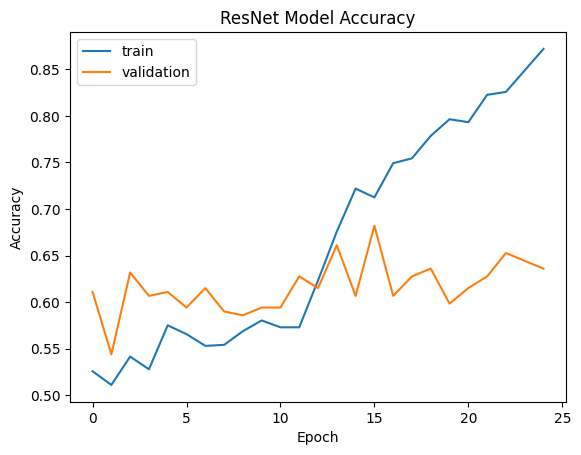

ResNet Model Evaluation Metrics
Accuracy: 0.6402
Precision: 0.6096
Recall: 0.7542
F1-score: 0.6742
VQAModel(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d

100%|██████████| 30/30 [00:10<00:00,  2.73it/s]


Epoch 0/24, Loss: 0.7867, Accuracy: 0.4753


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


Epoch 1/24, Loss: 0.7102, Accuracy: 0.5414


100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Epoch 2/24, Loss: 0.7001, Accuracy: 0.5540


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Epoch 3/24, Loss: 0.6821, Accuracy: 0.5813


100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


Epoch 4/24, Loss: 0.6748, Accuracy: 0.5876


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Epoch 5/24, Loss: 0.6438, Accuracy: 0.6222


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Epoch 6/24, Loss: 0.6397, Accuracy: 0.6264


100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Epoch 7/24, Loss: 0.6296, Accuracy: 0.6632


100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Epoch 8/24, Loss: 0.6463, Accuracy: 0.6201


100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


Epoch 9/24, Loss: 0.6163, Accuracy: 0.6558


100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


Epoch 10/24, Loss: 0.6036, Accuracy: 0.6695


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Epoch 11/24, Loss: 0.5713, Accuracy: 0.7020


100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch 12/24, Loss: 0.5352, Accuracy: 0.7440


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Epoch 13/24, Loss: 0.5426, Accuracy: 0.7440


100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Epoch 14/24, Loss: 0.4895, Accuracy: 0.7692


100%|██████████| 30/30 [00:11<00:00,  2.55it/s]


Epoch 15/24, Loss: 0.4217, Accuracy: 0.8090


100%|██████████| 30/30 [00:11<00:00,  2.53it/s]


Epoch 16/24, Loss: 0.4308, Accuracy: 0.8132


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


Epoch 17/24, Loss: 0.3846, Accuracy: 0.8342


100%|██████████| 30/30 [00:11<00:00,  2.51it/s]


Epoch 18/24, Loss: 0.3795, Accuracy: 0.8342


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Epoch 19/24, Loss: 0.3354, Accuracy: 0.8520


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


Epoch 20/24, Loss: 0.3417, Accuracy: 0.8615


100%|██████████| 30/30 [00:12<00:00,  2.38it/s]


Epoch 21/24, Loss: 0.3125, Accuracy: 0.8846


100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch 22/24, Loss: 0.3074, Accuracy: 0.8846


100%|██████████| 30/30 [00:11<00:00,  2.51it/s]


Epoch 23/24, Loss: 0.2861, Accuracy: 0.8825


100%|██████████| 30/30 [00:11<00:00,  2.50it/s]


Epoch 24/24, Loss: 0.2384, Accuracy: 0.9087
Best Validation Accuracy for VGGNet: 0.7615


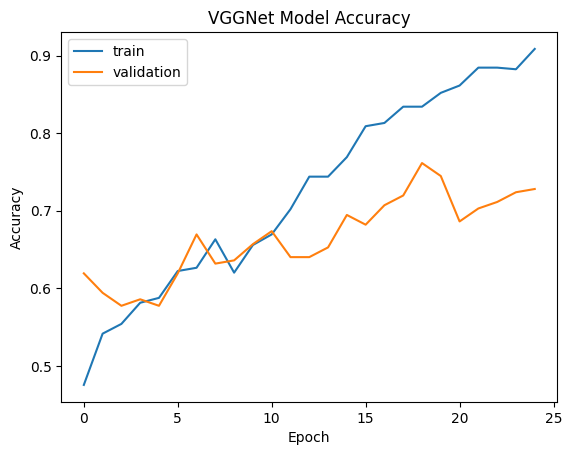

VGGNet Model Evaluation Metrics
Accuracy: 0.7029
Precision: 0.6880
Recall: 0.7288
F1-score: 0.7078


In [24]:
for model_name, base_model in models_dict.items():
    # Freeze model parameters
    for param in base_model.parameters():
        param.requires_grad = False
    
    # Replace the base model's fully connected layer
    if model_name == 'ResNet':
        feature_size = base_model.fc.in_features
        base_model.fc = nn.Flatten()
    elif model_name == 'VGGNet':
        feature_size = base_model.classifier[0].in_features
        base_model.classifier = nn.Sequential(nn.Flatten())
    
    model = VQAModel(base_model, vocab_size, feature_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
        
    # Print model summary
    print(model)

    # Training loop
    num_epochs = 25
    best_accuracy = 0.0
    best_model_wts = None
    
    # Create lists to store accuracy values
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for (images, sequences), labels in tqdm(train_loader):
            images, sequences, labels = images.to(device), sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, sequences)
            loss = criterion(outputs, labels.unsqueeze(1))  # Ensure labels are reshaped correctly
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            preds = torch.round(outputs)
            running_corrects += torch.sum(preds == labels.unsqueeze(1))
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        # Append accuracies to lists
        train_accuracies.append(epoch_acc.item())

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for (images, sequences), labels in val_loader:
                images, sequences, labels = images.to(device), sequences.to(device), labels.to(device)
                outputs = model(images, sequences)
                preds = torch.round(outputs)
                val_corrects += torch.sum(preds == labels.unsqueeze(1))
        
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_accuracies.append(val_acc.item())
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), f'best_{model_name}.pth')
    
    print(f"Best Validation Accuracy for {model_name}: {best_accuracy:.4f}")

    # Plot accuracy
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Evaluate model on validation data
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for (images, sequences), labels in val_loader:
            images, sequences, labels = images.to(device), sequences.to(device), labels.to(device)
            outputs = model(images, sequences)
            preds = torch.round(outputs).cpu().numpy()
            val_predictions.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    val_predictions = np.array(val_predictions).flatten()
    val_labels = np.array(val_labels).flatten()

    accuracy = accuracy_score(val_labels, val_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

    print(f"{model_name} Model Evaluation Metrics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")